# Анализ бизнес-показателей компании Procrastinate Pro+

Требуется изучить бизнес-показатели компании и понять причины, по которым, затраты на рекламу не окупаются последние несколько месяцев, несмотря на большие инвестиции в данное направление.

В нашем распоряжении данные о пользователях, привлеченных с 1 мая по 27 октября 2019 года. Данные хранятся в трех таблицах - лог сервера с данными об их посещениях, выгрузка их покупок за этот период и рекламные расходы.

# Цель исследования

Необходимо изучить:
- Откуда приходят пользователи и какими устройствами они пользуются.
- Сколько стоит привлечение пользователей из различных рекламных каналов.
- Сколько денег приносит каждый клиент.
- Когда расходы на привлечение клиента окупаются.
- Какие факторы мешают привлечению клиентов.

# План исследования

План анализа данных:
- Подготовка данных к анализу.
- Задать функции для расчета и анализа LTV, ROI, удержания и конверсии.
- Провести исследовательский анализ данных.
- Изучить маркетинговые показатели компании.
- Оценить окупаемость рекламы.
- Сделать общий вывод по результатам анализа.

## Предобработка данных.

### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

### Загрузка таблиц.

In [2]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
    costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')

###  Знакомство с данными.

In [44]:
visits.head(5)

user_id         region   device  channel       session_start  \
0  981449118918  United States   iPhone  organic 2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic 2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic 2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop 2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic 2019-05-01 03:33:35   

          session_end  
0 2019-05-01 02:45:01  
1 2019-05-01 04:47:35  
2 2019-05-01 15:32:08  
3 2019-05-01 00:54:25  
4 2019-05-01 03:57:40

In [45]:
orders.head(5)

user_id            event_dt  revenue
0  188246423999 2019-05-01 23:09:52     4.99
1  174361394180 2019-05-01 12:24:04     4.99
2  529610067795 2019-05-01 11:34:04     4.99
3  319939546352 2019-05-01 15:34:40     4.99
4  366000285810 2019-05-01 13:59:51     4.99

In [46]:
costs.head(5)

dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

Первая таблица хранит информацию о пользователе - его стране, устройстве и канале привлечения. 

Во второй - информация о покупке. 

В третьей - информация о стоимосте заказа.

### Информация о таблицах

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [6]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Можно привести названия столбцов к нижнему регистру и изменить тип данных в столбцах с датой. Пропусков нет.

### Привожу столбцы к нижнему регистру, убираю пробелы

In [7]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

### Привожу столбцы к нужному типу

In [8]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

### Проверка на наличие дубликатов

In [47]:
print('Количество дубликатов в таблице visits:', visits.duplicated().sum())
print('Количество дубликатов в таблице orders:', orders.duplicated().sum())
print('Количество дубликатов в таблице costs:', costs.duplicated().sum())

Количество дубликатов в таблице visits: 0
Количество дубликатов в таблице orders: 0
Количество дубликатов в таблице costs: 0


Проведена предобработка данных:
- Привел названия столбцов к нижнему регистру и убрал пробелы.
- Привел столбцы с датами к типу datetime.
- Выполнил проверку на дубликаты - явных дубликатов нет.

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии

### Функция для создания профилей пользователей

In [10]:
def get_profiles(sessions, orders, ad_costs):

    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

 
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция для подсчёта Retention Rate

In [11]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    dimensions = ['payer'] + dimensions
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time 

### Функция для подсчёта конверсии

In [12]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time 

### Функция для подсчёта LTV и ROI

In [13]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  
        result_grouped,  
        result_in_time,  
        roi_grouped,  
        roi_in_time,  
    ) 

### Функция для сглаживания данных

In [14]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

### Функция для построения графика Retention Rate

In [15]:
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))
    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')
    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### Функция для построения графика конверсии

In [16]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))
    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Функция для визуализации LTV и ROI

In [17]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))
    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

### Составляем профили пользователей, определяем минимальную и максимальную даты привлечения пользователей

#### Создаю профили пользователей

In [21]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5))

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


#### Определяю минимальную и максимальную дату привлечения пользователей

In [22]:
print('Минимальная дата', profiles['first_ts'].min())
print('Максимальная дата', profiles['first_ts'].max())

Минимальная дата 2019-05-01 00:00:41
Максимальная дата 2019-10-27 23:59:04


Исходя из технического задания, изучаемый период с 1 мая по 27 октября 2019 года. Даты совпадают с данными из таблицы.

### Выясняем из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей

#### Устанавливаю момент и горизон анализа

In [23]:
observation_date = datetime(2019, 10, 13).date()
horizon_days = 14

#### Проверяю на какую страну приходится больше всего платящих пользователей

In [49]:
sum = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'sum'}).sort_values(by='payer', ascending=False)
sum['payer_%'] = (sum['payer']/sum['user_id'])*100
sum['payer_%'] = round(sum['payer_%'], 1)
sum.sort_values(by = 'payer_%', ascending = False)

user_id  payer  payer_%
region                                
United States   100002   6902      6.9
Germany          14981    616      4.1
UK               17575    700      4.0
France           17450    663      3.8

Пользователи приходят из 4 стран - Франция, Германия, Англия и США. Больше всего пользователей из США. 

Лидер по доли покупателй США с 6.9%.

### Вясняю какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи

In [25]:
sum = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'sum'}).sort_values(by='payer', ascending=False)
sum['payer_%'] = (sum['payer']/sum['user_id'])*100
sum['payer_%'] = round(sum['payer_%'], 1)
sum.sort_values(by = 'payer_%', ascending = False)

user_id  payer  payer_%
device                          
Mac        30042   1912      6.4
iPhone     54479   3382      6.2
Android    35032   2050      5.9
PC         30455   1537      5.0

Пользователи используют Андроид, Мак, ПК и Айфон. Лидером среди устройств по колличеству пользователей является Айфон. Лидер по доле покупателей - Мак.

### Изучаю рекламные источники привлечения и определяю каналы, из которых пришло больше всего платящих пользователей

In [26]:
sum = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'sum'}).sort_values(by='payer', ascending=False)
sum['payer_%'] = (sum['payer']/sum['user_id'])*100
sum['payer_%'] = round(sum['payer_%'], 1)
sum.sort_values(by = 'payer_%', ascending = False)

user_id  payer  payer_%
channel                                    
FaceBoom              29144   3557     12.2
AdNonSense             3880    440     11.3
lambdaMediaAds         2149    225     10.5
TipTop                19561   1878      9.6
RocketSuperAds         4448    352      7.9
WahooNetBanner         8553    453      5.3
YRabbit                4312    165      3.8
MediaTornado           4364    156      3.6
LeapBob                8553    262      3.1
OppleCreativeMedia     8605    233      2.7
organic               56439   1160      2.1

В нашем распоряжении 11 каналов привлечения пользователей. Лидер по привлечению платных пользователей - Faceboom. Меньше всего платных пользователей приходит из MediaTornado. Тройка лидеров по доле покупателей - FaceBoom, AdNonSense и LambdaMediaAds.

## Маркетинг

### Посмотрим на общую сумму расходов на маркетинг

In [27]:
channel_sum = profiles.pivot_table(index = 'channel', values = 'acquisition_cost', aggfunc = 'sum').sort_values(by = 'acquisition_cost', ascending = False)
print(channel_sum)
print(channel_sum['acquisition_cost'].sum())

                    acquisition_cost
channel                             
TipTop                      54751.30
FaceBoom                    32445.60
WahooNetBanner               5151.00
AdNonSense                   3911.25
OppleCreativeMedia           2151.25
RocketSuperAds               1833.00
LeapBob                      1797.60
lambdaMediaAds               1557.60
MediaTornado                  954.48
YRabbit                       944.22
organic                         0.00
105497.3


Больше всего компания инвестирует в TipTop и FaceBoom. Маркетинговый бюджет 105 497.

### Строю визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику

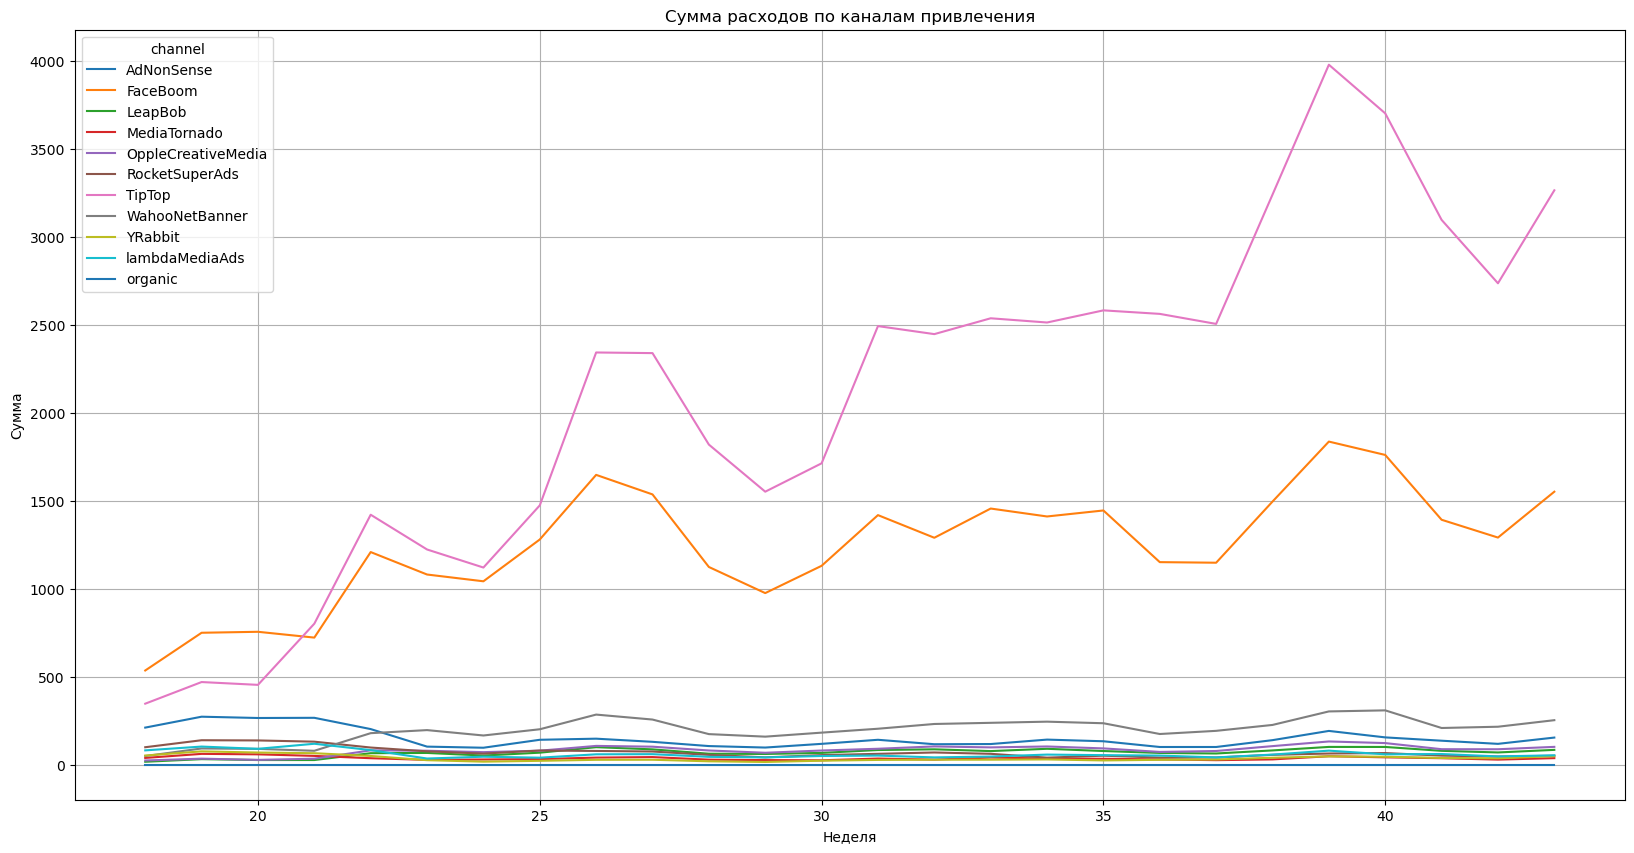

In [28]:
profiles['week'] = profiles['first_ts'].dt.isocalendar().week
profiles['month'] = profiles['first_ts'].dt.month
profiles.pivot_table(index ='week', columns = 'channel', values = 'acquisition_cost', aggfunc = 'sum').plot(figsize = (20, 10), grid = True)
plt.ylabel('Сумма')
plt.xlabel('Неделя')
plt.title('Сумма расходов по каналам привлечения')
plt.show()

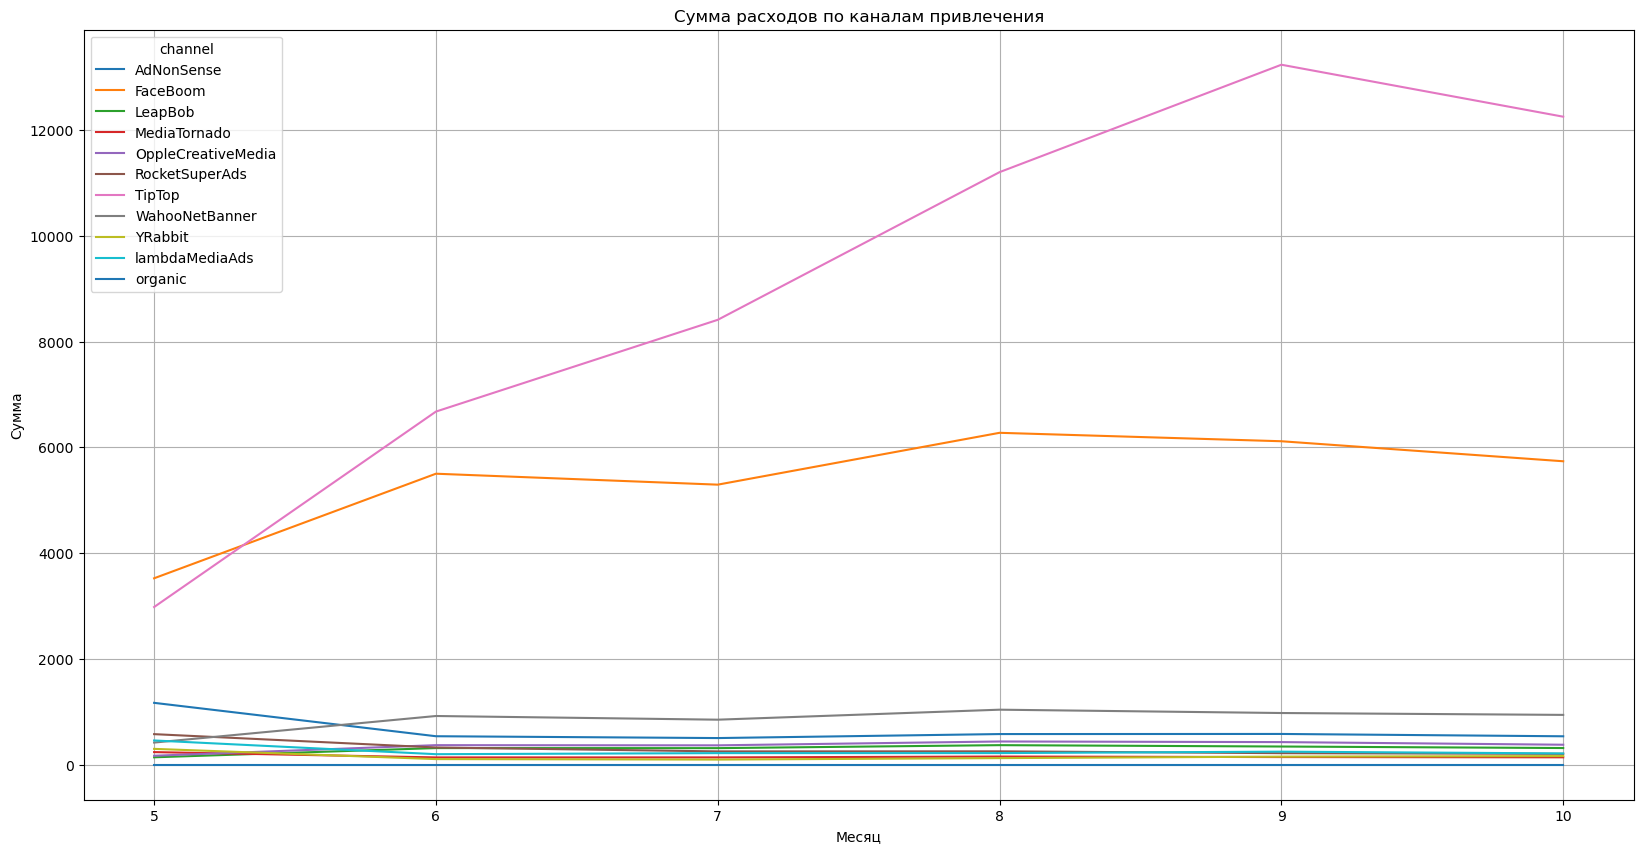

In [29]:
profiles.pivot_table(index ='month', columns = 'channel', values = 'acquisition_cost', aggfunc = 'sum').plot(figsize = (20, 10), grid = True)
plt.ylabel('Сумма')
plt.xlabel('Месяц')
plt.title('Сумма расходов по каналам привлечения')
plt.show()

Практически с самого начала компания инвестировала средства только в два канала привлечения. Хотя в начале были попытки инвестировать в AdNonSense.

### Узнаем сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника

In [30]:
sum = profiles.pivot_table(index = 'channel', values = ['acquisition_cost', 'user_id'], aggfunc = {'user_id' : 'count', 'acquisition_cost' : 'sum'})
sum['cost_per_person'] = sum['acquisition_cost']/sum['user_id']
sum.sort_values( by = 'cost_per_person')

acquisition_cost  user_id  cost_per_person
channel                                                       
organic                         0.00    56439         0.000000
LeapBob                      1797.60     8553         0.210172
MediaTornado                  954.48     4364         0.218717
YRabbit                       944.22     4312         0.218975
OppleCreativeMedia           2151.25     8605         0.250000
RocketSuperAds               1833.00     4448         0.412095
WahooNetBanner               5151.00     8553         0.602245
lambdaMediaAds               1557.60     2149         0.724802
AdNonSense                   3911.25     3880         1.008054
FaceBoom                    32445.60    29144         1.113286
TipTop                      54751.30    19561         2.799003

Органические пользователи - бесплатные, как и ожидалось. Самые дорогие пользователи приходят из TipTop.

- Общая сумма, которую компания может инвестировать в маркетинг - 105497. Основная часть этих средств идет в два канала привлечения - FaceBoom и TipTop.
- Изучив таблицу. распределение расходов на маркетинг по времени, сделал вывод, что данного решения компания придерживается все последнее время, постепенно увеличивая инвестиции в данные каналы. В остальные каналы компания не инвестирует.
- Рассчитал стоимость привлечение клиента с разбивкой по каналам привлеччения. Самые дорогие клиенты из AdNonSense, FaceBoom и TipTop. Клиент из TipTop в два раза дороже, чем клиент из FaceBoom.

## Оценим окупаемость рекламы

### Проанализирую окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI

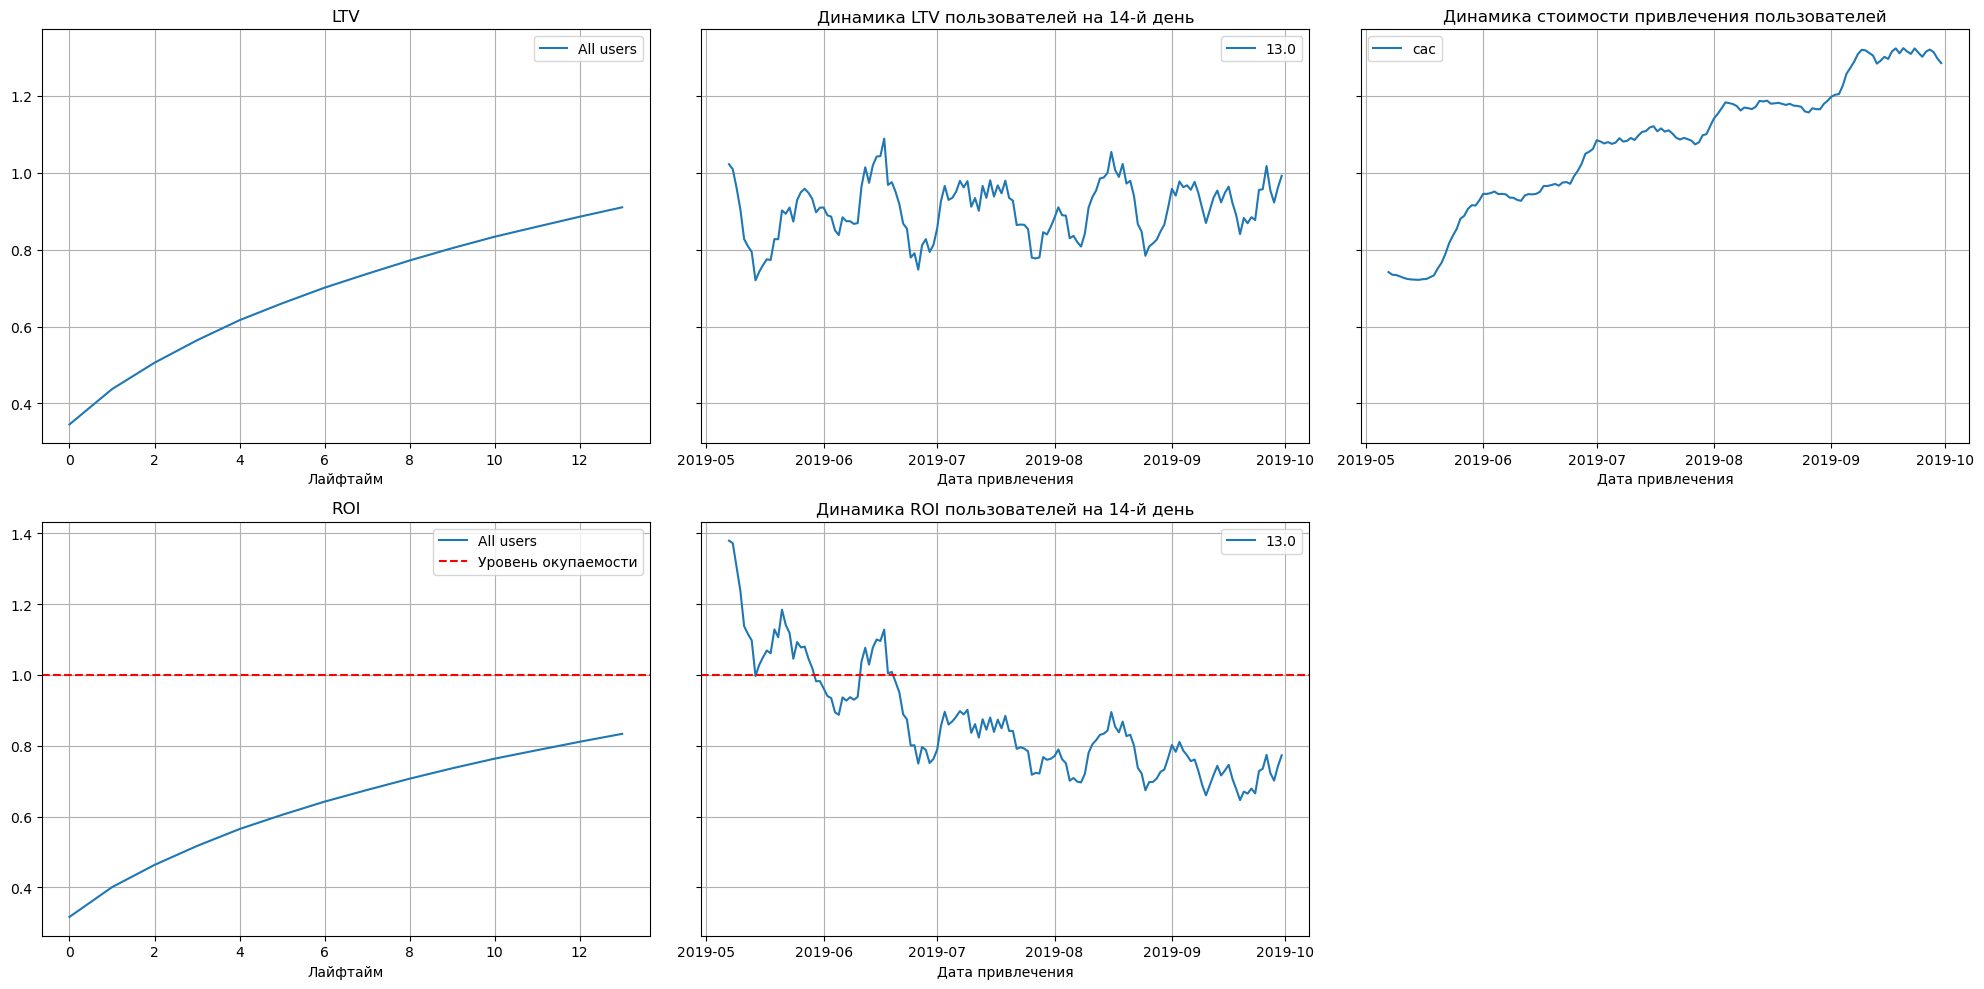

In [31]:
tv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)
    

Исходя из технического задания, пользователи должны окупаться за 2 недели.

Грфик ROI показывает, что реклама не окупается. САС растет, значит цена привлечения новых пользователей увеличивается. LTV повышается, значит с данными все впорядке.

### Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей

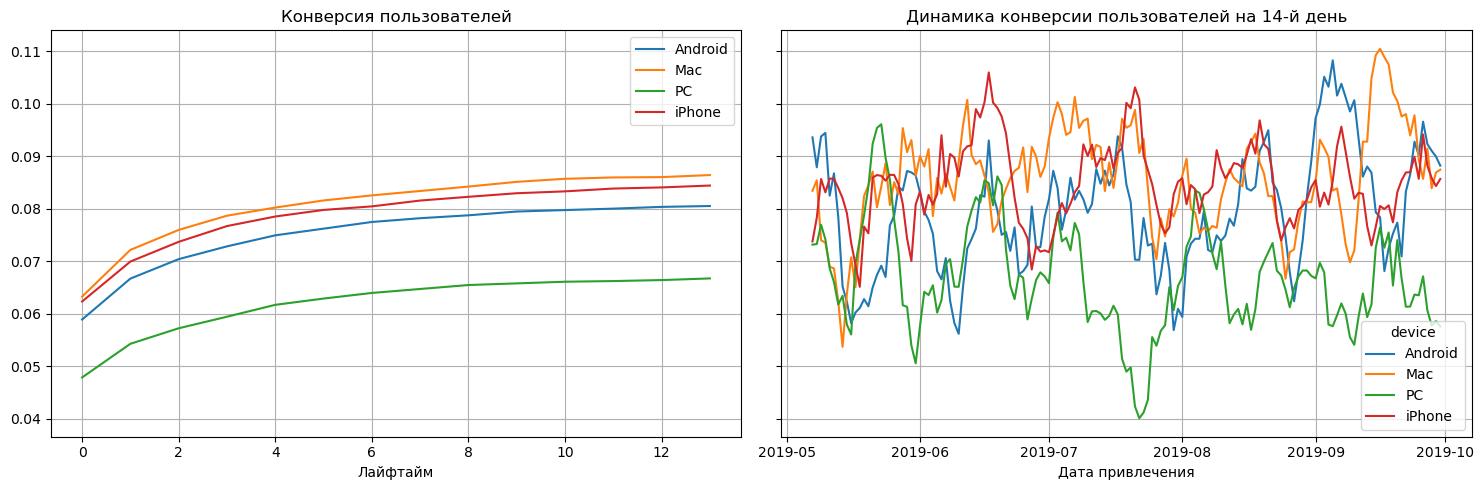

In [32]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions= ['device'])
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Пользователи Андроид, МАК и Айфон конвертируются гораздо лучше, пользователей с ПК.

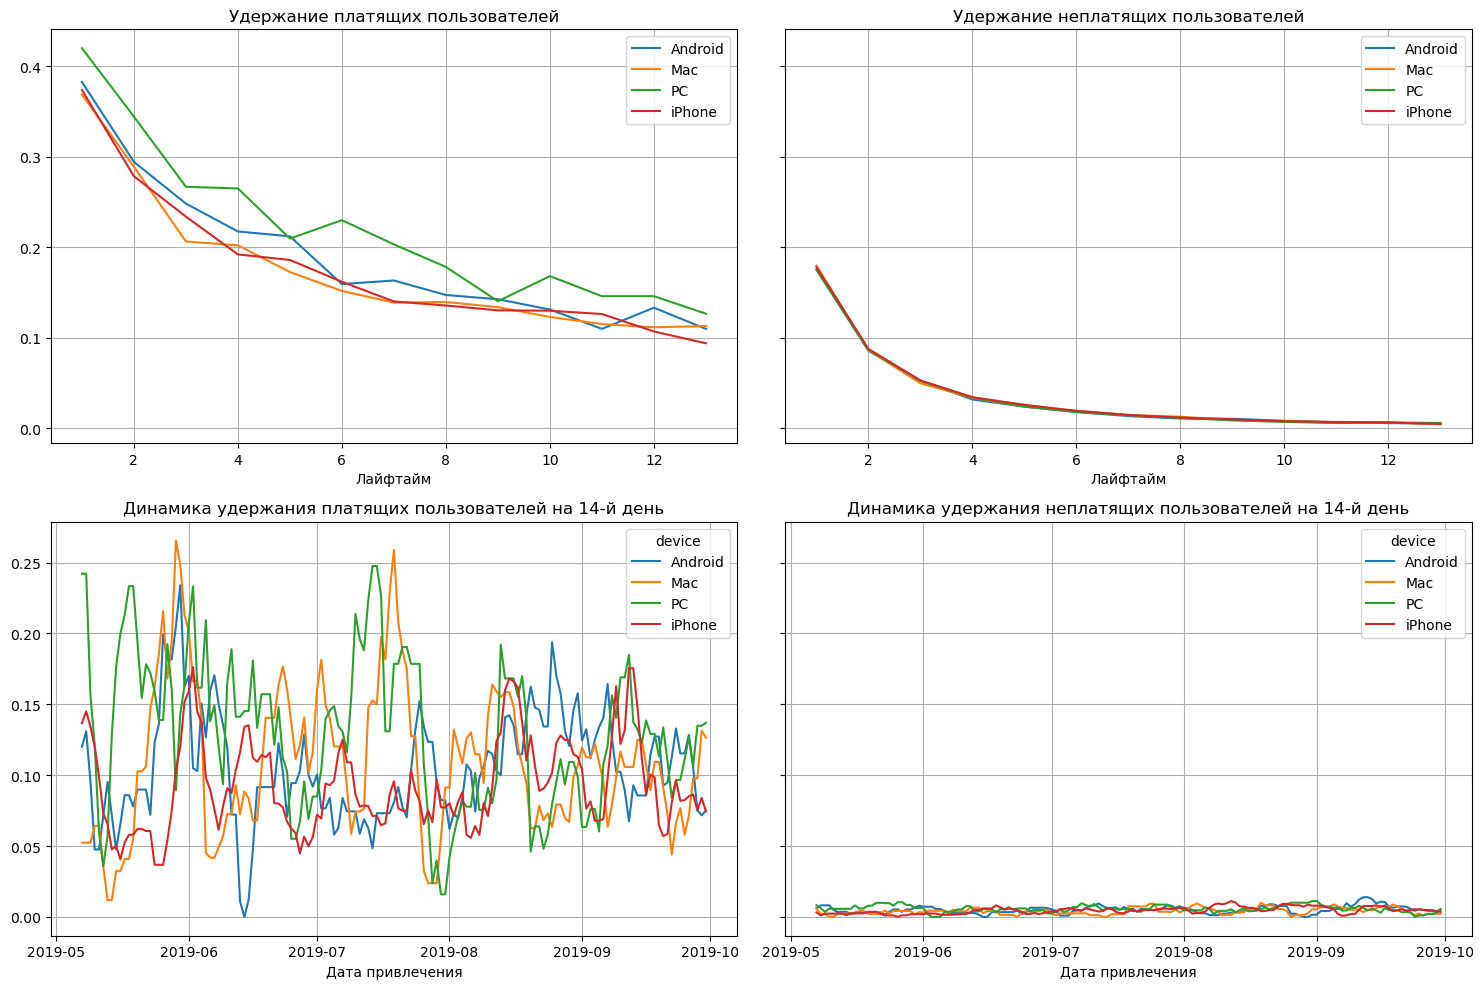

In [33]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles[profiles['channel'] != 'organic'], visits, observation_date, horizon_days, dimensions=['device'])
plot_retention(retention_grouped, retention_history, horizon_days)

Удержание пользователей на разных устройствах примерно одинаковое. Попробуем посмотреть по стране.

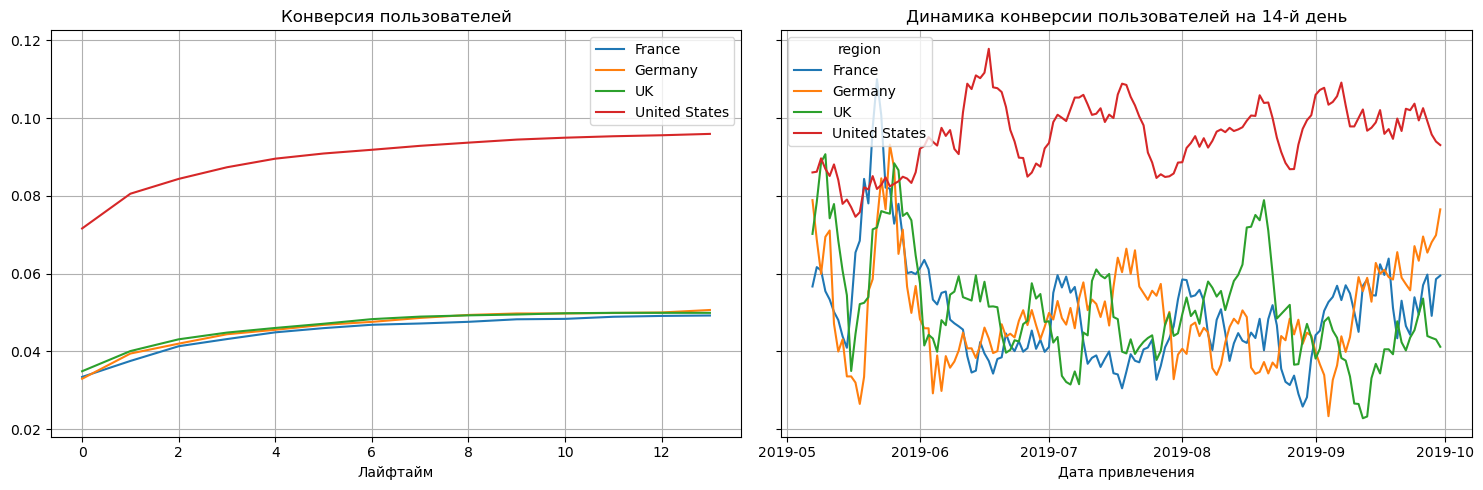

In [34]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions= ['region'])
plot_conversion(conversion_grouped, conversion_history, horizon_days)

По конверсии лидирует США, с хорошим отрывом

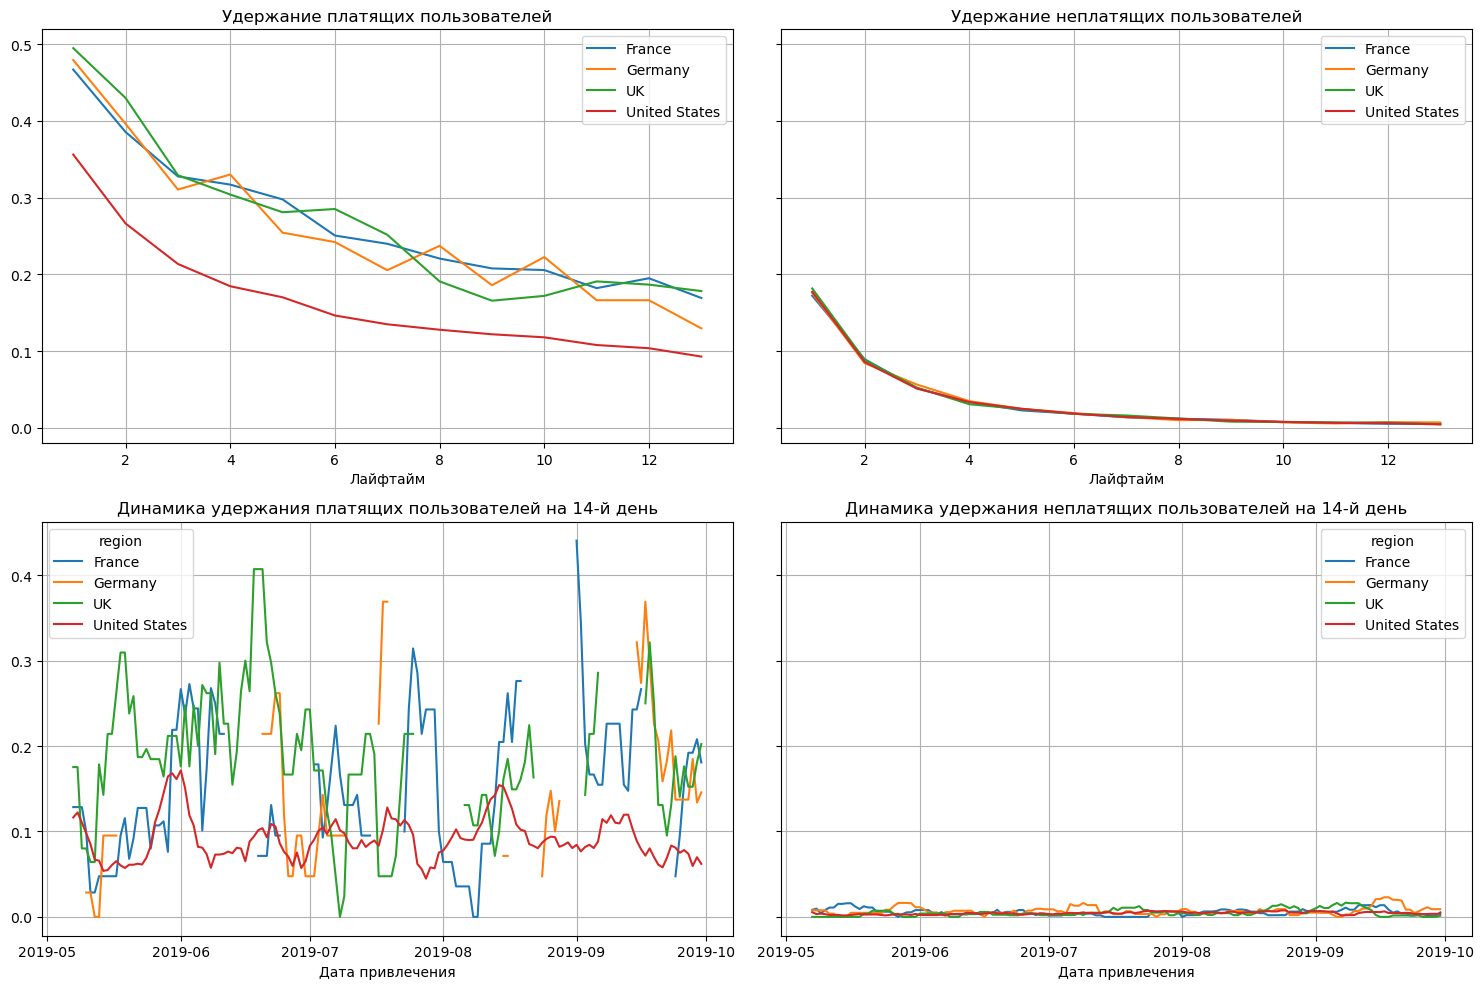

In [35]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles[profiles['channel'] != 'organic'], visits, observation_date, horizon_days, dimensions=['region'])
plot_retention(retention_grouped, retention_history, horizon_days)

А вот удержание платящищ пользователей из США показывает самый низкий результат.

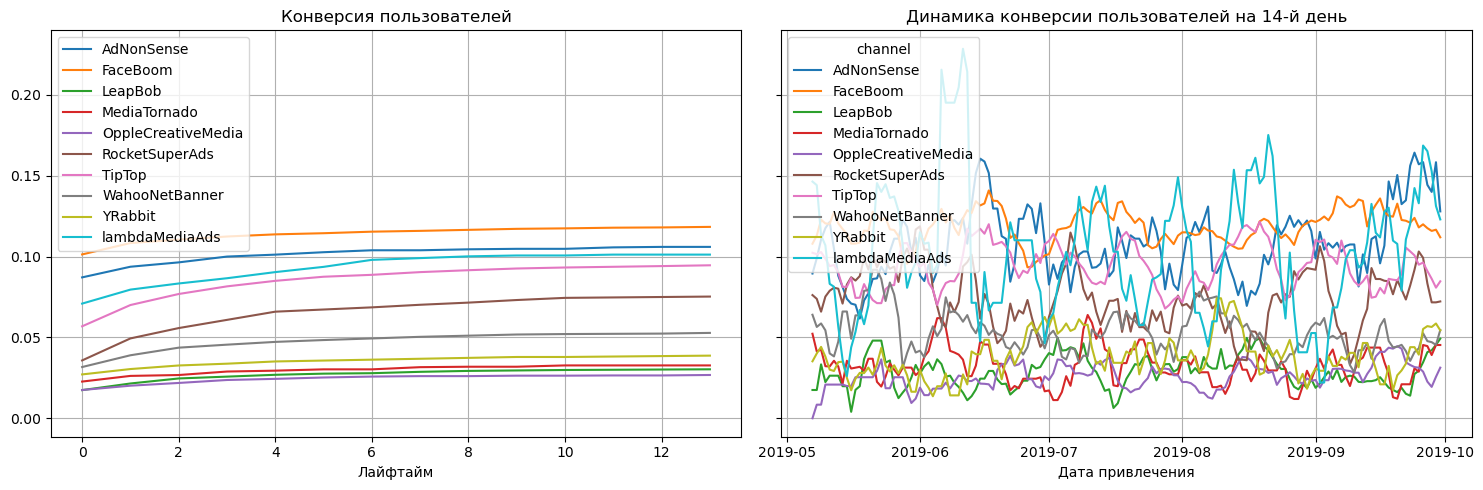

In [36]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions= ['channel'])
plot_conversion(conversion_grouped, conversion_history, horizon_days)

По конвеверсии лидирует канал FaceBoom.

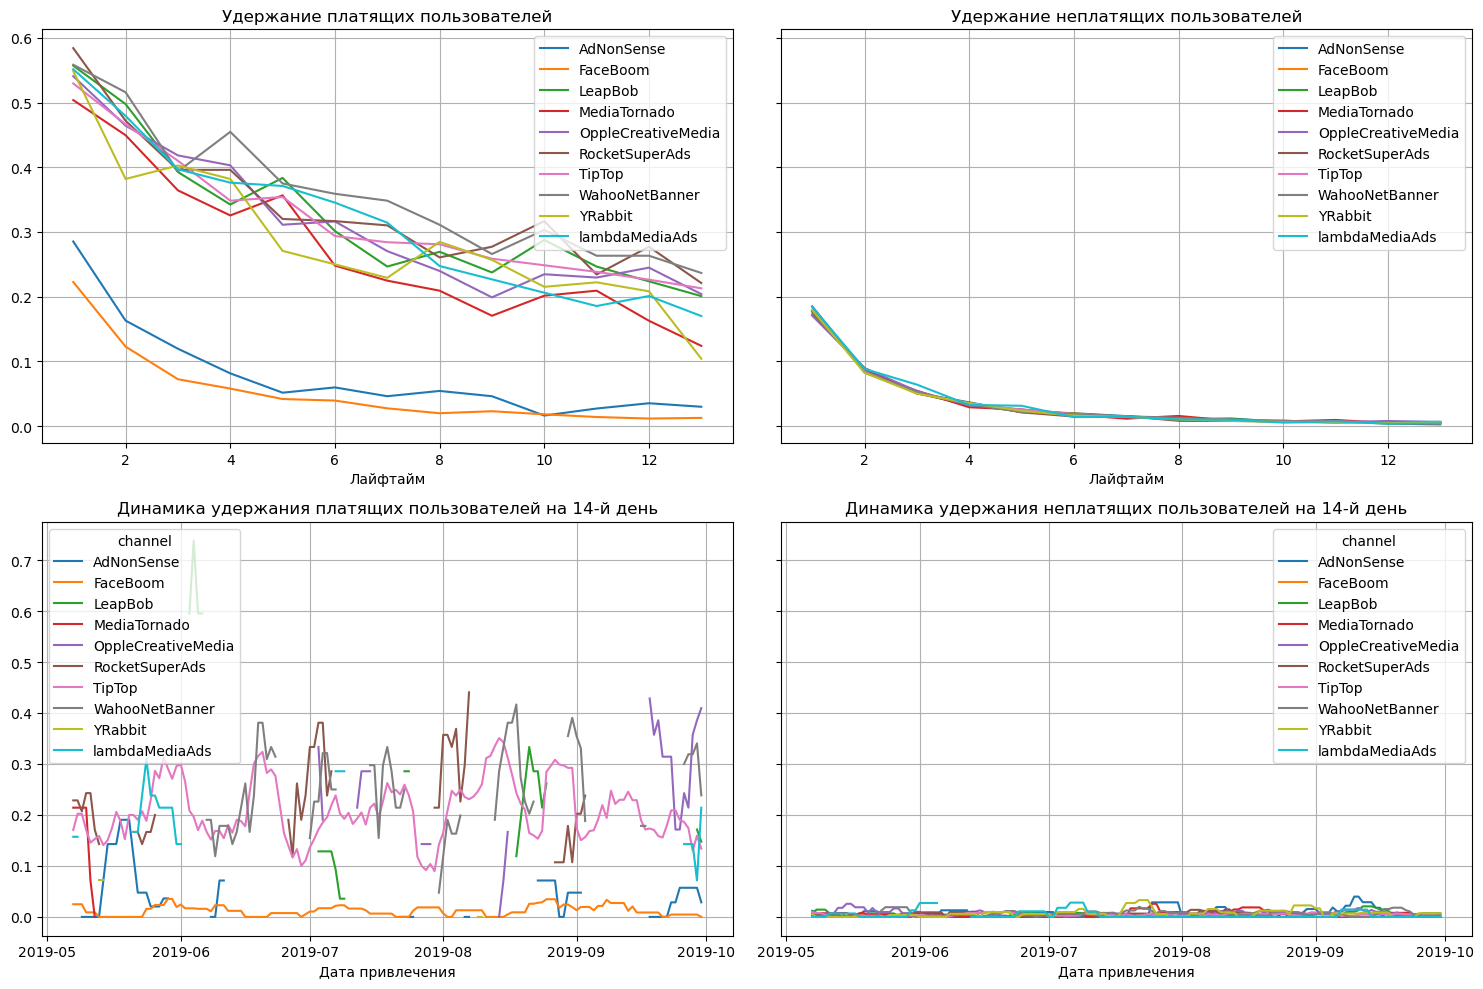

In [37]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles[profiles['channel'] != 'organic'], visits, observation_date, horizon_days, dimensions=['channel'])
plot_retention(retention_grouped, retention_history, horizon_days)

Выделяются каналы FaceBoom и AsNonSense - у них худшие показатели удержания платных пользователей.

### Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI

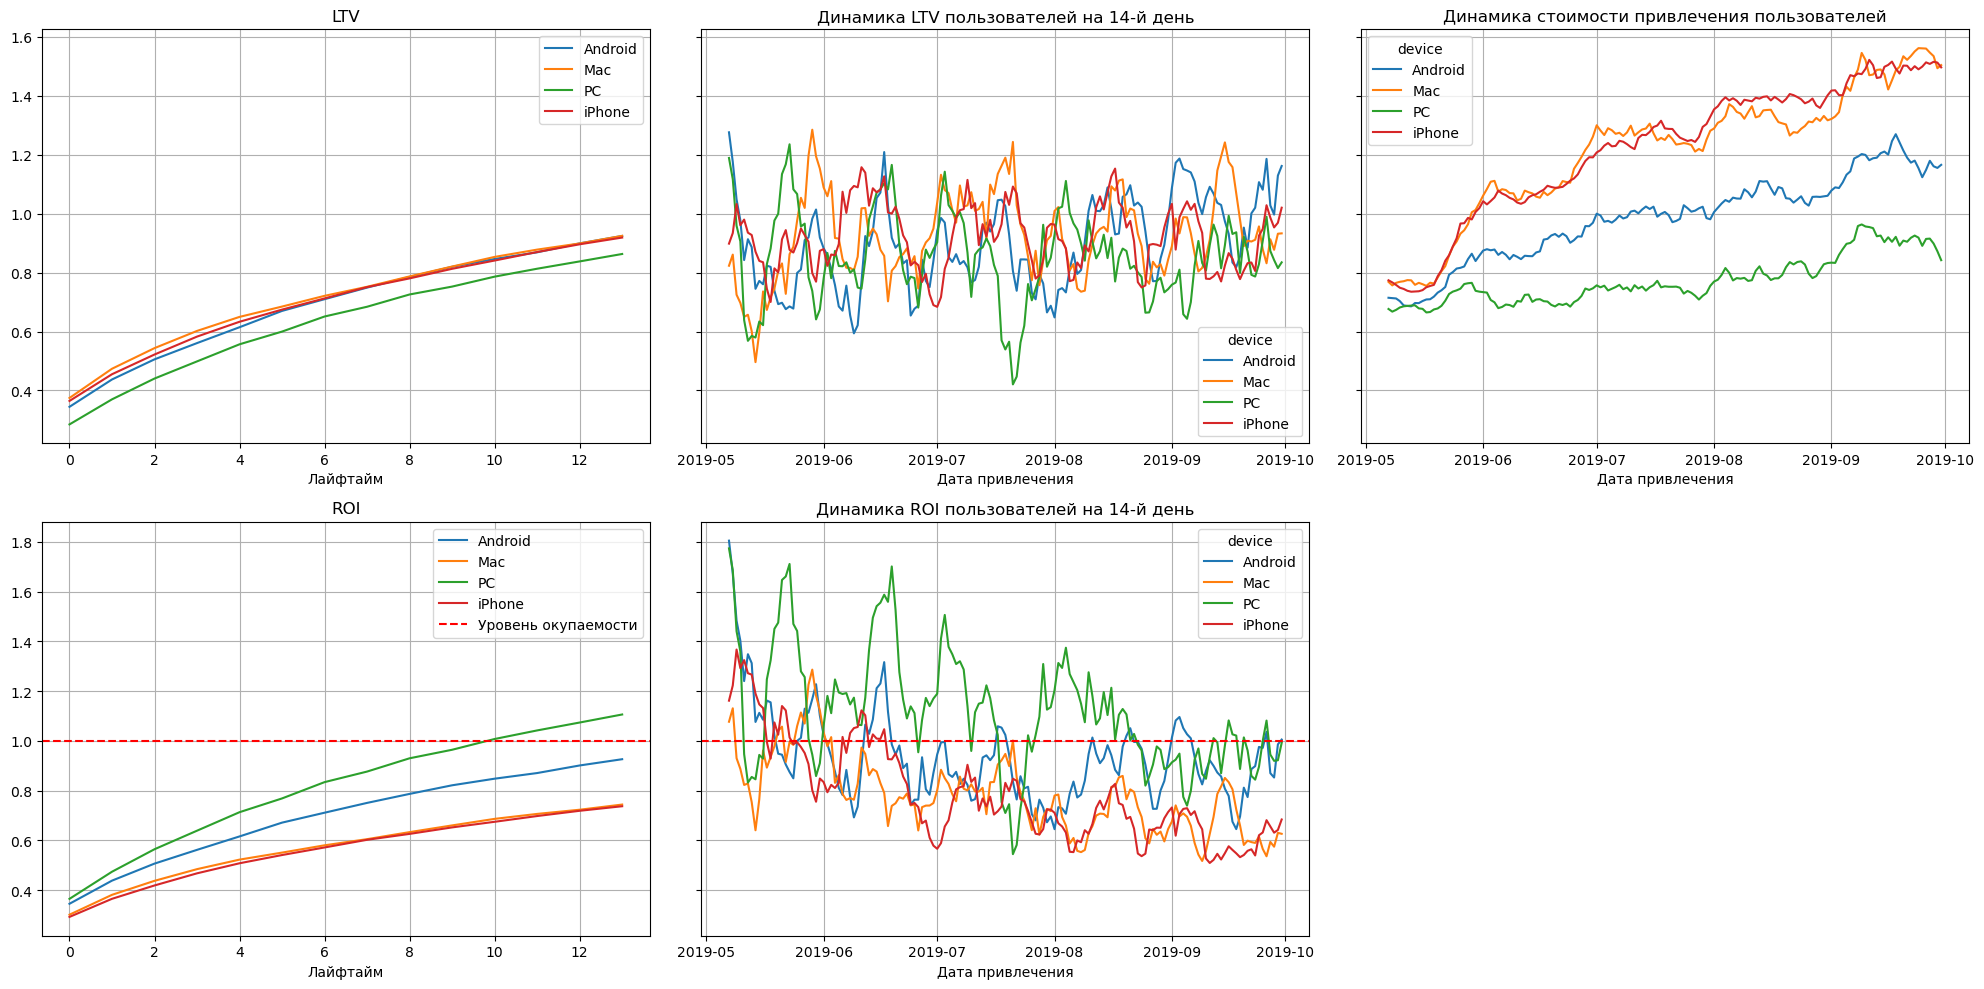

In [38]:
tv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=['device'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

LTV у всех стабилен, стоимость привлечения пользователей увеличилась на всех устройствах. За 14 дней реклама окупается только на ПК, но в динамике видим, что и он с сентября перестанет окупаться.

### Проанализируем окупаемость рекламы с разбивкой по странам

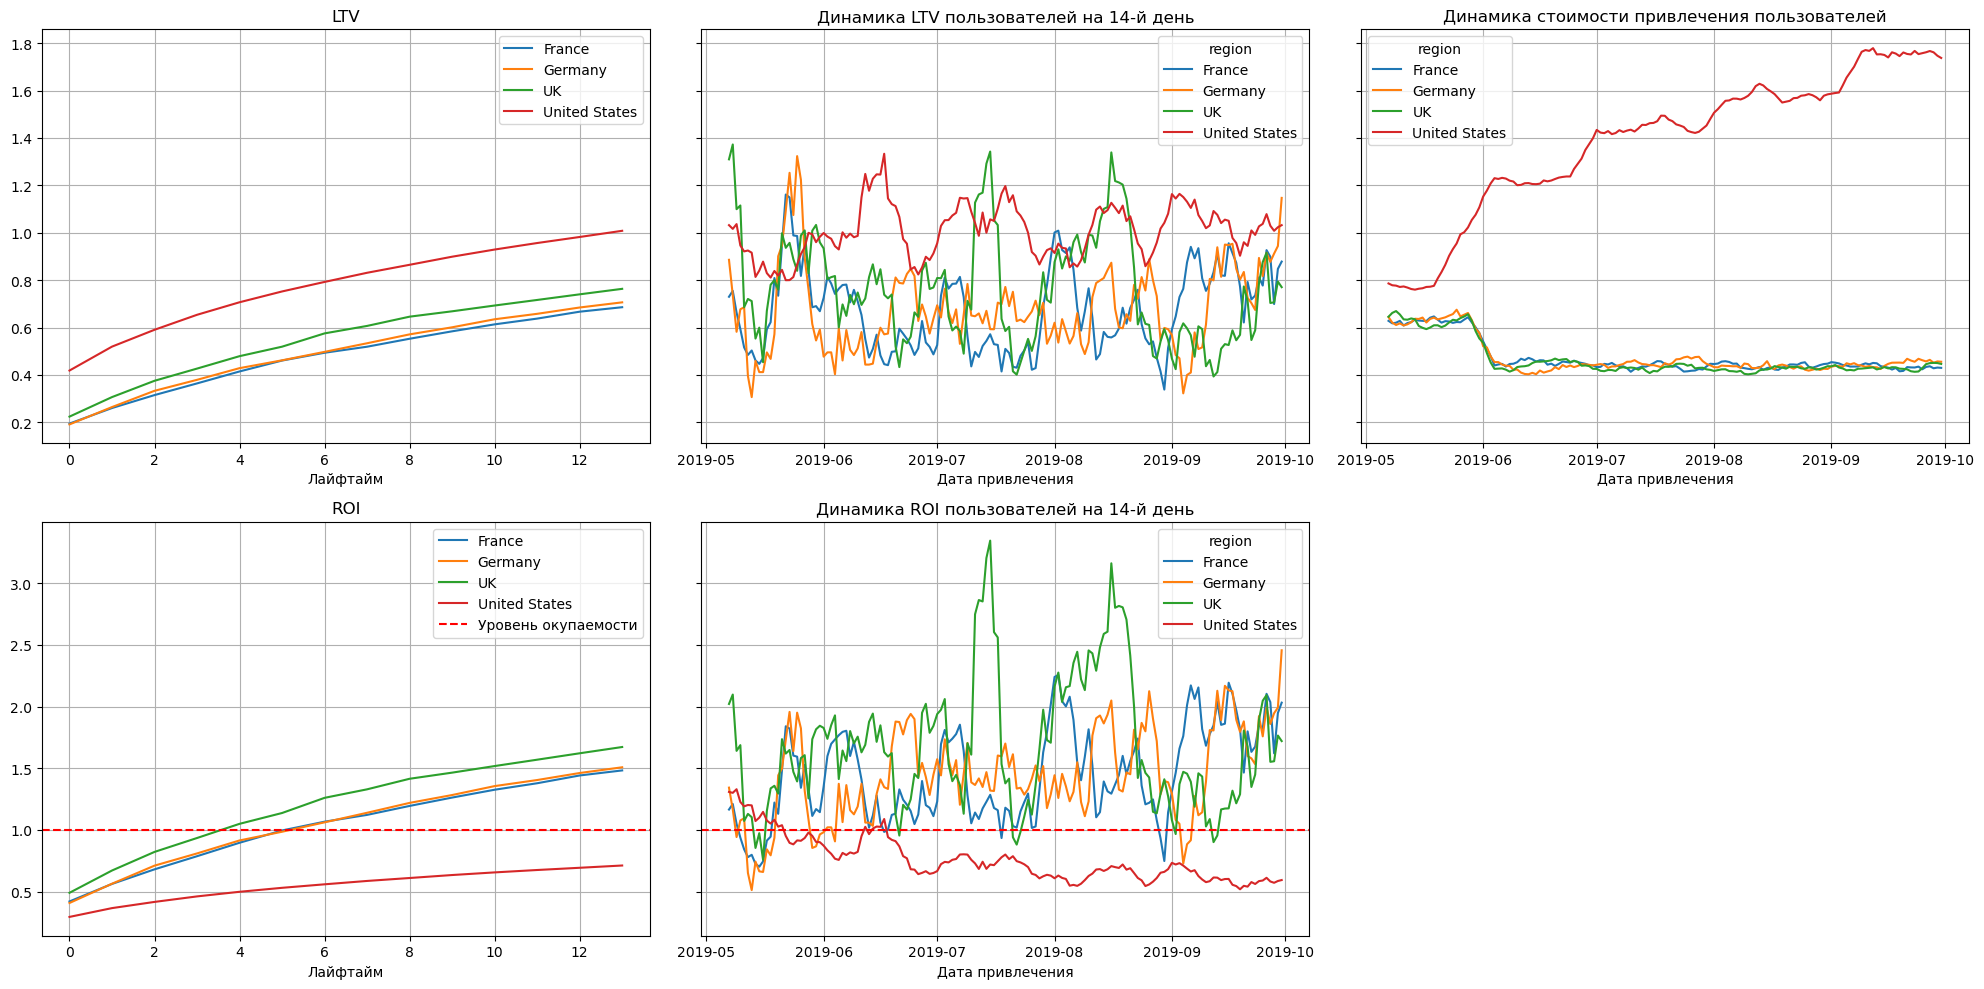

In [39]:
tv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=['region'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам видно, что именно в США резко увеличилась сумма привлечения пользователей, и только в США реклама перестала окупаться.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

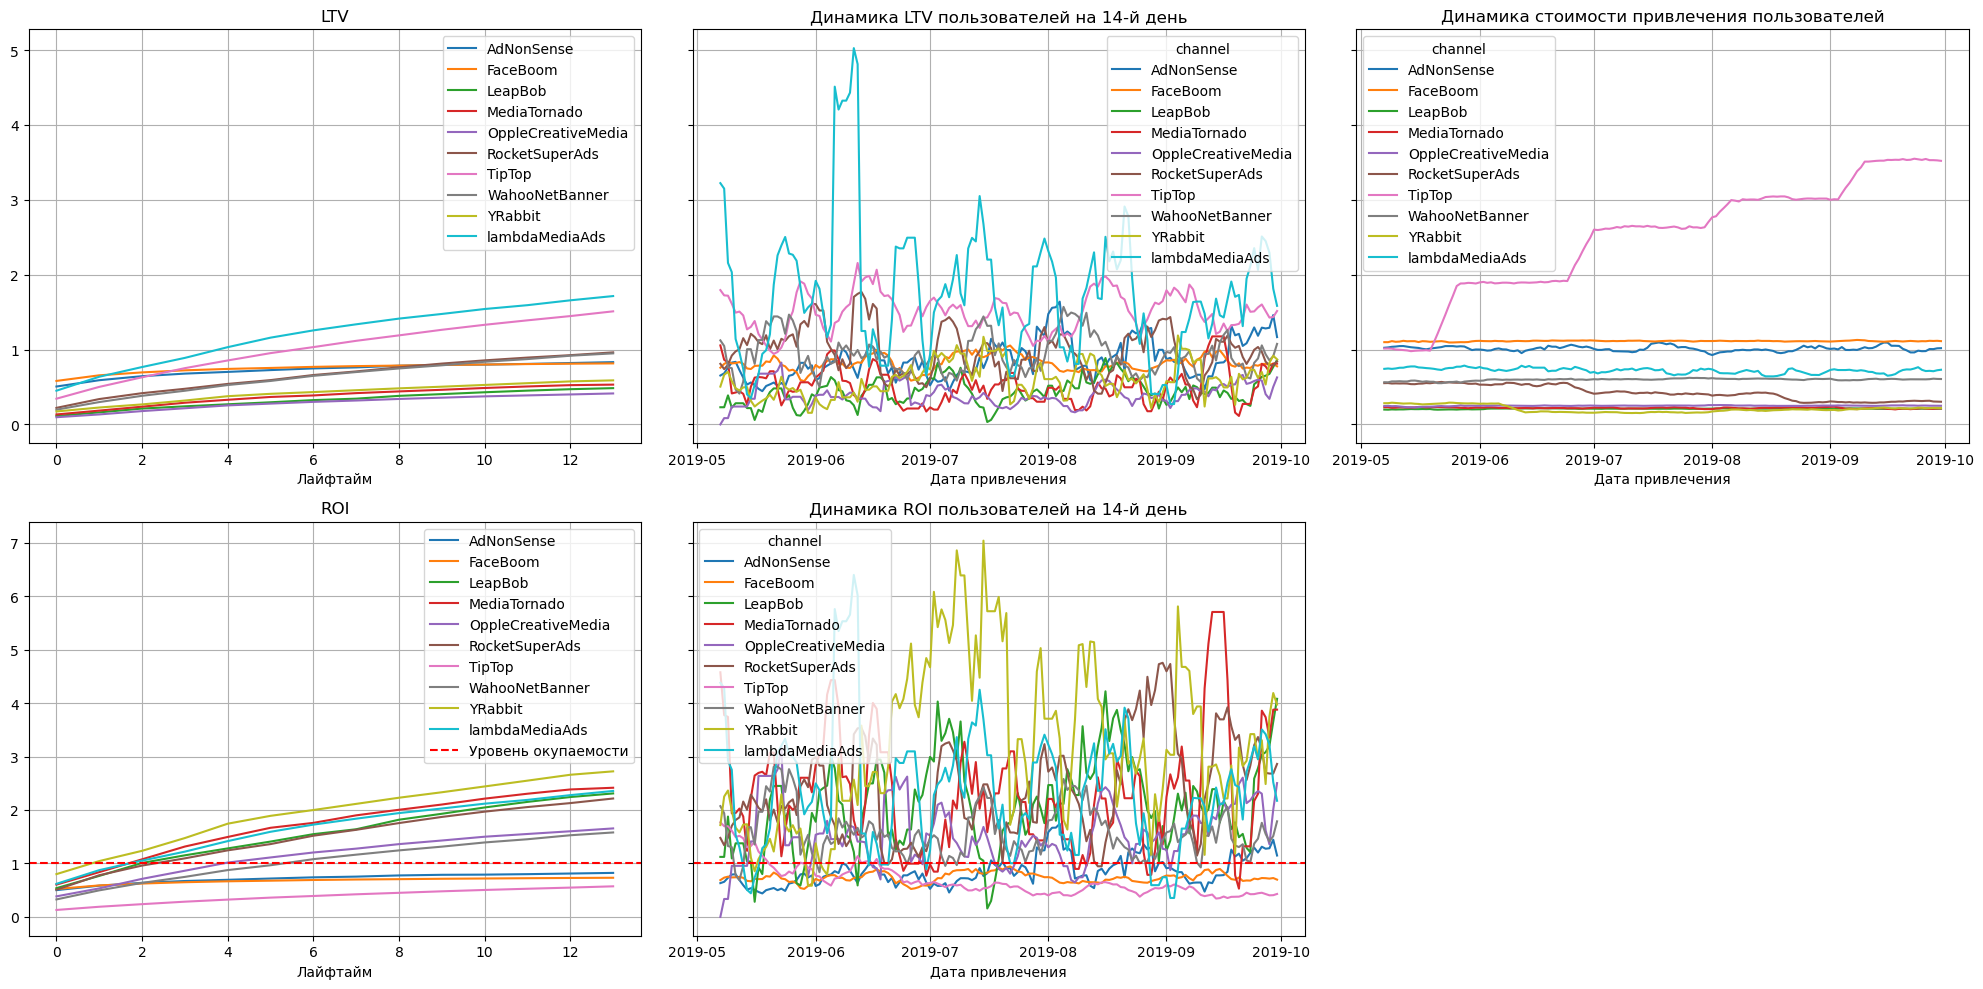

In [40]:
tv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=['channel'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Реклама не окупается в трех каналах - AdNonSense, FaceBoom и TipTop.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам в США

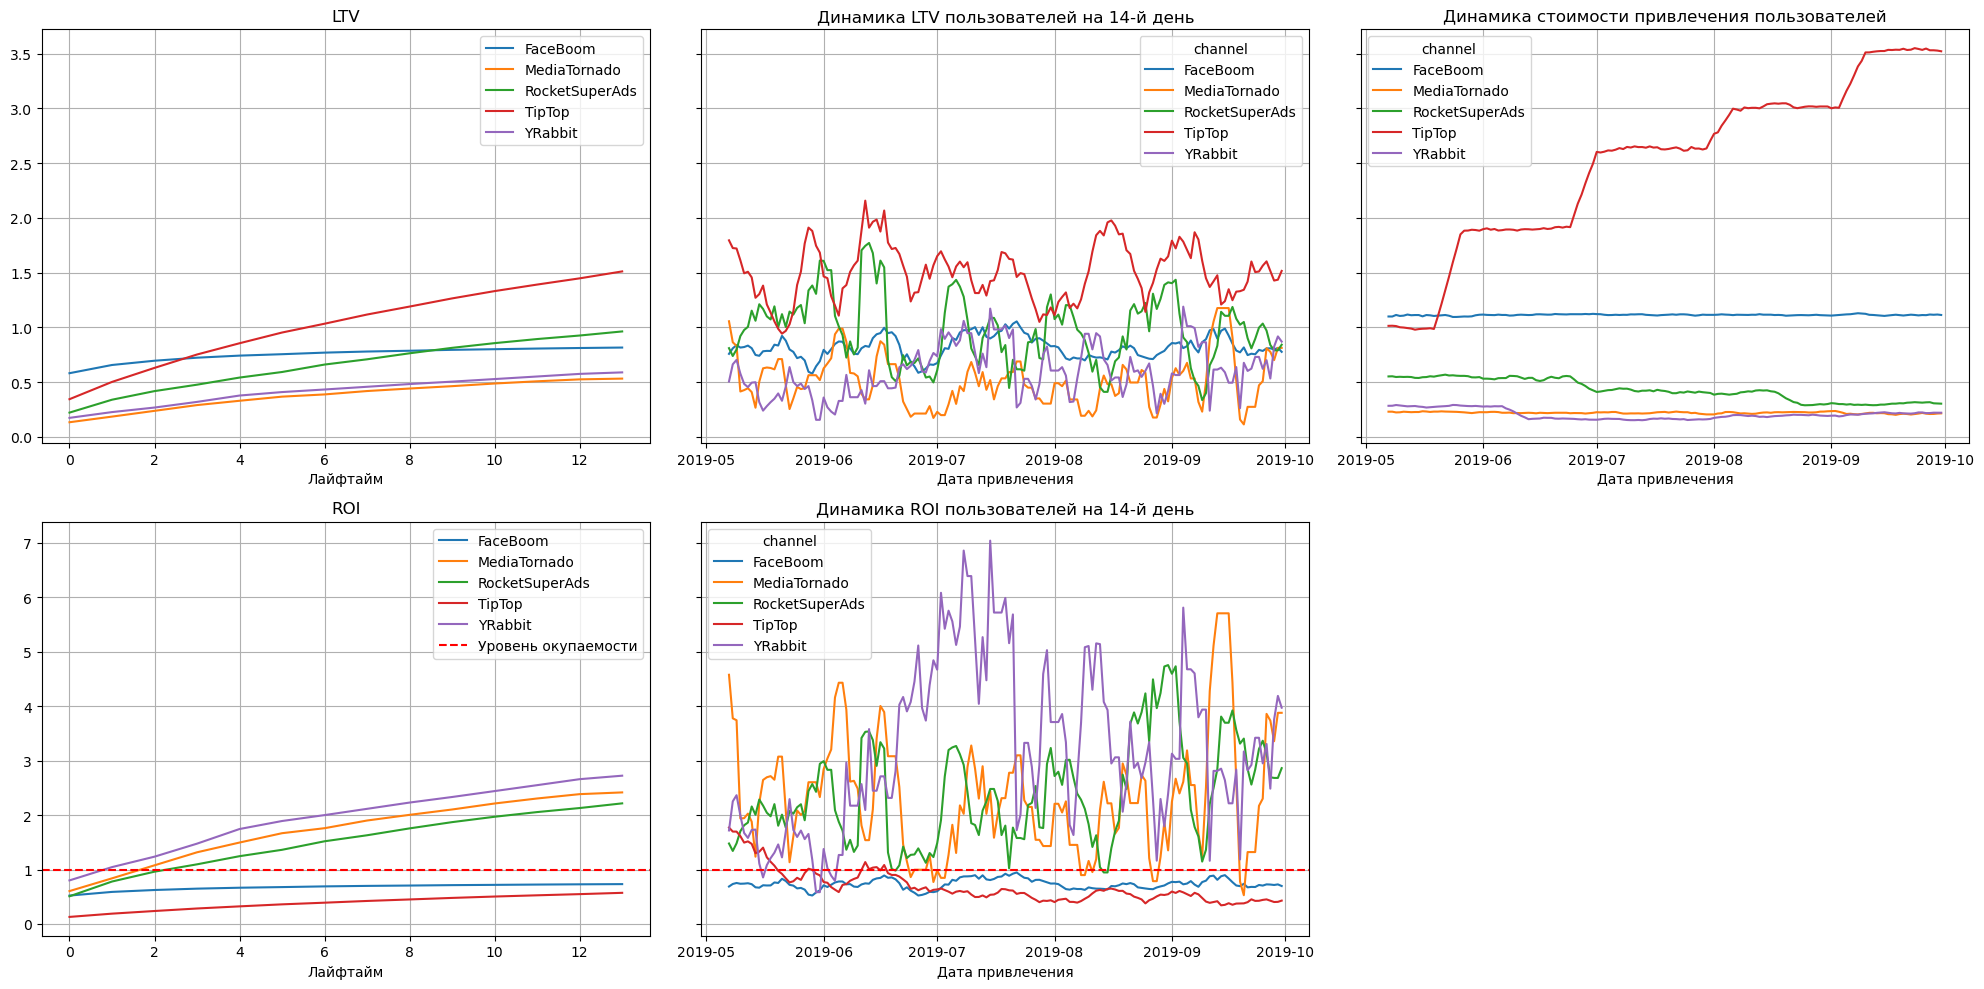

In [41]:
profiles_usa = profiles.query('region == "United States"')
tv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa[profiles_usa['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=['channel'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

В США окупаются 3 канала - YRabbit, MediaTornado и RocketSuperAds. TipTop и FaceBoom не окупаются, в канале TipTop серьезно выросла цена привлечения клиентов.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам в Европе.

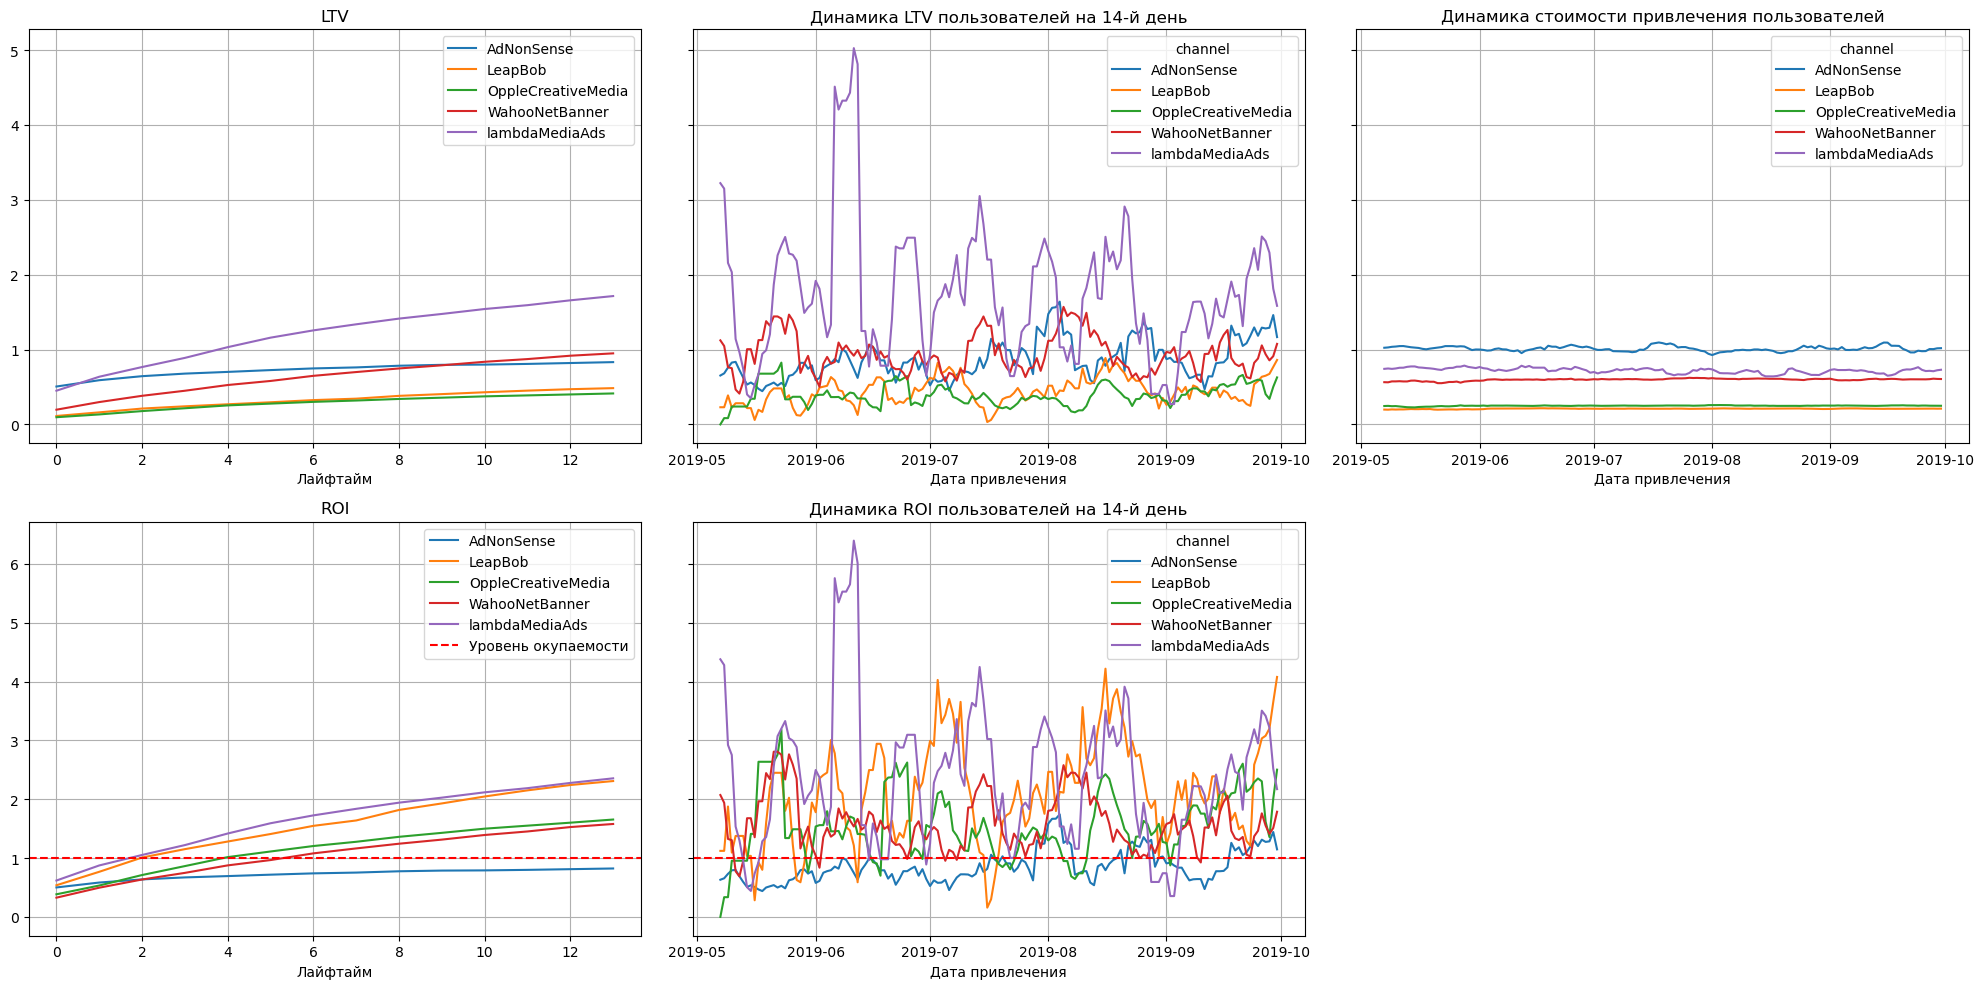

In [42]:
profiles_eu = profiles.query('region != "United States"')
tv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_eu[profiles_eu['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=['channel'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

В Европе канал AdNonsense не окупается. Лучшие показатели у IambdaMediaAds и LeapBob. 

### Вывод по окупаемости рекламы.

- На данный момент реклама в целом окупается. 
- Проблема неокупаемости рекламы сосредоточена в регионе США по каналу привлечения TipTop на устройстве Айфон.
- Так как у нас по сути два канала привлечения - TipTop и FaceBoom. Самый крупный регион продаж США. Из-за того, что проблема возникла в самом крупном канале привлечения и в самом крупном регионе, проблема сказалась на всем бизнесе в целом.
- Необходимо срочно проверить, в чем возникает проблема у пользователей из США, когда они используют канал TipTop черех Айфон.

- Провел предобработку данных и озакомился с датасетами. Данных разделены на 3 таблицы. Была выполнены проверка на дубликаты и исправлены некорректные названия столбцов.
- Были добавлены функции для расчетов и визуализации данных.
- Был выполнен исследовательский анализ данных.
-- Создал уникальные профили пользователей.
-- Определил максимальную и минимальную дату привлечения пользователей. Минимальная дата - 01.05.2019, максимальная - 27.10.2019.
-- Определил из каких стран приходят пользователи и на какую страну приходится больше всего пользователей. Пользователи приходят из 4 стран - Германии, Франции, Англии и США. Наибольшее колличество пользователей из США.
-- Выяснил какими устройствами пользуются пользователи и какие устройства предпочитают платящие пользователи. Пользователи используют 4 устройства - ПК, МАК, Андроид и Айфон. Наибольшее колличество платящих пользователей предпочитают Айфон. Однако, наибольшая доля покупателей на Мак.
-- Изучил каналы привлечения пользователей. Всего 11 каналов, наибольшее колличество платящих пользователей пришли из FaceBoom и TipTop. Наибольшая доля покупающих пользователей из FaceBoom, Adnonsense и Iambdamediads.
- Провел анализ маркетинга компании.
-- Изучил общую сумму расходов на маркетинг. Она равна 105 497 "рублей". Более половины бюджета тратится на TipTop. Так же большую сумму компания инвестирует в FaceBoom. 
-- Построил визуализацию динамики изменения суммы инвестирования на маркетинг. С годами прослеживается увелечение инвестиции в оба канала привлечения. 
-- Изучил сколько стоило привлечение пользователя по каналам. Самые дорогие покупатели из TipTop со стоимостью 2.8 в среднем. Органические пользователи приходят бесплатно, как и ожидалось. 
- Изучил окупаемость рекламы.
-- Выяснил, что у компании в целом реклама не окупается. Также. стремительно растет стоимость привлечения прользователей. 
- Изучил конверсию и удержание пользователей с разбивкой по странам, устройствам и каналам привлечения. 
-- Выяснил, что ПК отстает по конверсии от остальных устройств.
-- Удержание на всех устройствах одинаковое.
-- Из стран наилучший показатель конверсии у США.
-- Худший показатель удержания пользоватлей также показывает США.
-- Лидер по конверсии канал привлечения пользователей - FaceBoom.
-- Худшие показатели удержания пользователей показываеют каналы AdNonSense и FaceBoom.
-- Изучил окупаемость рекламы с разбивкой по устройствам. Только пользователи на ПК окупаются. Рост стоимости привлечения клиентов показывают все устройства.
-- Изучил окупаемость рекламы с разбивкой по странам. Выяснил, что реклама не окупается только в США. Рост стоимости привлечения клиентов в США серьезно вырос. В остальных странах показатель уменьшается. 
-- Изучил окупаемость рекламы с разбивкой по каналам привлечения. Выяснил, что реклама не окупается в трех каналах - AdNonsense, FaceBoom и TipTop. Стоимость привлечения клиентов серьезно выросла в TipTop.
-- Изучил окупаемость реклама с разбивкой по каналам в США. Окупаются 3 канала - YRabbit, MediaTornado и RocketSuperAds. TipTop и FaceBoom не окупаются, в канале TipTop серьезно выросла цена привлечения клиентов.
-- Изучил окупаемость рекламы с разбивкой по каналам в Европе. Канал AdNonsense не окупается. Лучшие показатели у IambdaMediaAds и LeapBob. 
- Можно сделать вывод, что причиной плохих показателей всей компании, является регион США - резкое уменьшение удержания пользователей. Проблему следует искать в каналах привлечения AdNonSense и FaceBoom - резкое снижение удержания пользователей. Также стоит обратить внимание на каналы AdNonsense, FaceBoom и TipTop - рекалама. в них перестала окупаться. Канал Tiptop демонстрирует резкое увеличение стоимости пользователей. 
- Из рекомендаций, могу предложить развивать самые успешные направления. Для более точной рекомендации каналов привллечения пользователей - разделим регионы на Европу и США.
-- В США нужно увеличить инвестиции в каналы - YRabbit, MediaTornado и RocketSuperAds.
-- В Европе лучшие каналы для привлечения пользователей - IambdaMediaAds и LeapBob.
-- Также приоритетная платформа для развития - ПК.